In [1]:
import json
import torch

MODELS = [
    "Alibaba-NLP/gte-large-en-v1.5",
    "intfloat/multilingual-e5-large",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-MiniLM-L6-v2"
]

DATA_PATH = '../data/sentence-embeddings'
RELATIONS_JSON_PATH = '../data/relations.json'

In [2]:
DATA_PATH

'../data/sentence-embeddings'

In [3]:
with open(RELATIONS_JSON_PATH, 'r') as f:
    relations = json.load(f)['spatial_relations']

In [4]:
def get_relations_lookup(relations):
    relations_lookup = {}
    for category, category_pairs in relations.items():
        for first, second in category_pairs:
            relations_lookup[first] = {'category': category, 'opposite': second, 'position': 0}
            relations_lookup[second] = {'category': category, 'opposite': first, 'position': 1}
    return relations_lookup

relations_lookup = get_relations_lookup(relations)

In [5]:
def load_embeddings_for_model(model_name, relations_lookup):
    embeddings = {}
    raw_data = torch.load(f'{DATA_PATH}/{model_name.replace('/', '_')}.pt', weights_only=False)
    for data_point in raw_data:
        embeddings[data_point['sentence']] = data_point
        relation = data_point['relation']
        data_point['category'] = relations_lookup[relation]['category']
    return embeddings

embeddings = load_embeddings_for_model(MODELS[3], relations_lookup)

In [6]:
def get_pair_differences(embeddings):
    pair_data = []
    for sentence, sentence_data_point in embeddings.items():
        curr_embedding = sentence_data_point['embedding']
        curr_relation = sentence_data_point['relation']
        opposite_relation = relations_lookup[curr_relation]['opposite']
        if relations_lookup[curr_relation]['position'] == 0: # Ensure no duplicates
            opposite_sentence = sentence.replace(f'is {curr_relation} the', f'is {opposite_relation} the')
            opposite_embedding = embeddings[opposite_sentence]['embedding']
            sentence_difference = curr_embedding - opposite_embedding
            pair_data.append({
                'sentence': sentence,
                'opposite_sentence': opposite_sentence,
                'embedding_difference': sentence_difference,
                'category': relations_lookup[curr_relation]['category'],
                'relation_pair': f'{curr_relation}-{opposite_relation}'
            })
    return pair_data

embeddings_pair_data = get_pair_differences(embeddings)

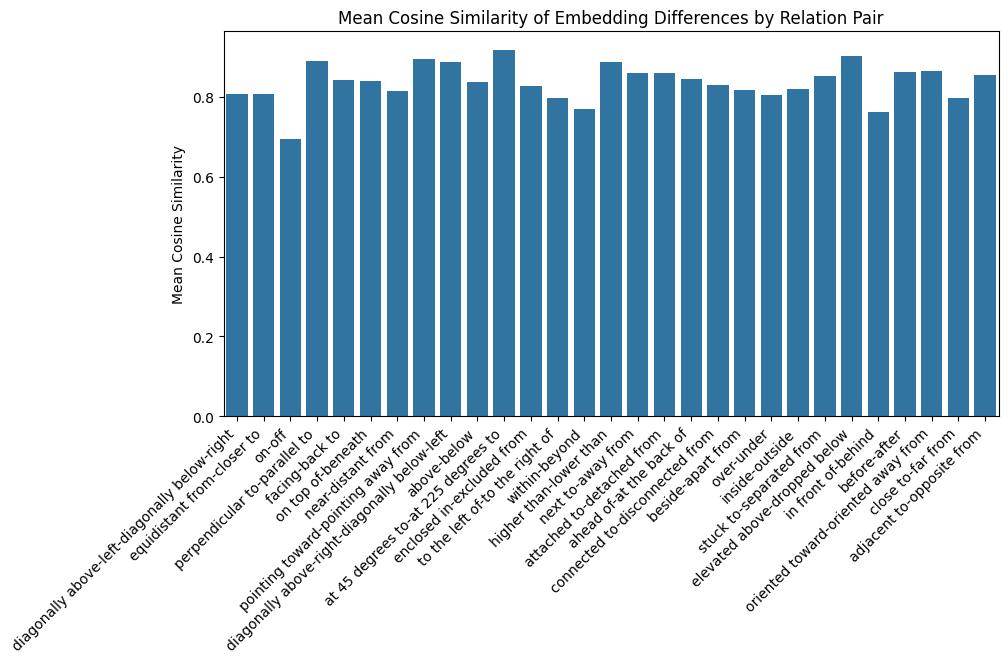

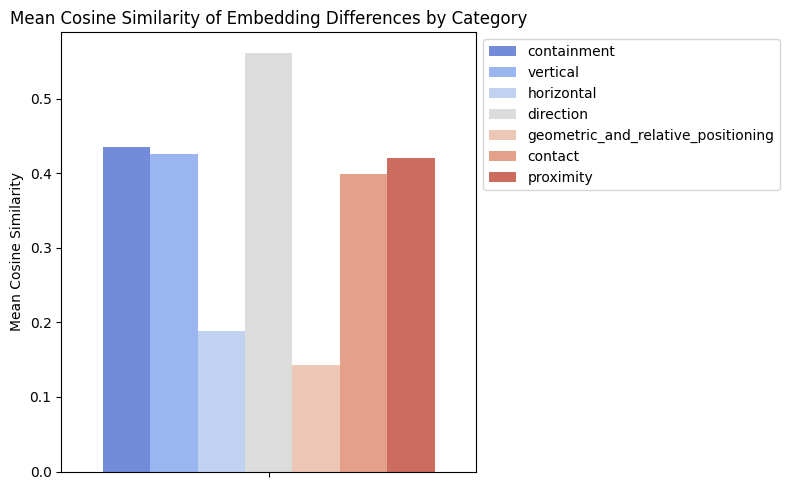

In [7]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

relation_pairs = []
categories = []
embedding_diffs = []

for entry in embeddings_pair_data:
    relation_pairs.append(entry['relation_pair'])
    categories.append(entry['category'])
    embedding_diffs.append(entry['embedding_difference'])

embedding_diffs = np.array(embedding_diffs)

# Get unique relation pairs and categories
unique_relations = list(set(relation_pairs))
unique_categories = list(set(categories))

# Function to compute mean cosine similarity within a given grouping (relation pair or category)
def compute_cosine_similarity(embeddings, labels, group_list):
    similarity_scores = {}
    
    for group in group_list:
        indices = [i for i, label in enumerate(labels) if label == group]
        if len(indices) < 2:
            continue  # Skip if there's only one example
        vectors = embeddings[indices]
        
        # Compute pairwise cosine similarity
        cos_sim = cosine_similarity(vectors)
        mean_sim = np.mean(cos_sim[np.triu_indices(len(cos_sim), k=1)])  # Exclude diagonal
        similarity_scores[group] = mean_sim
    
    return similarity_scores

# Compute cosine similarity per relation pair
cosine_scores_relations = compute_cosine_similarity(embedding_diffs, relation_pairs, unique_relations)

# Compute cosine similarity per category
cosine_scores_categories = compute_cosine_similarity(embedding_diffs, categories, unique_categories)

# Plot cosine similarity for relation pairs
plt.figure(figsize=(10, 5))
sns.barplot(x=list(cosine_scores_relations.keys()), y=list(cosine_scores_relations.values()))
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity of Embedding Differences by Relation Pair")
plt.show()

# Plot cosine similarity for categories
plt.figure(figsize=(8, 5))
ax = sns.barplot(hue=list(cosine_scores_categories.keys()), y=list(cosine_scores_categories.values()), palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity of Embedding Differences by Category")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
plt.tight_layout()
plt.show()

In [ ]:
similarity_scores = {}

vectors = [entry['embedding'] for entry in embeddings.values()]

# Compute pairwise cosine similarity
cos_sim = cosine_similarity(vectors)
mean_sim = np.mean(cos_sim[np.triu_indices(len(cos_sim), k=1)])  # Exclude diagonal
mean_sim

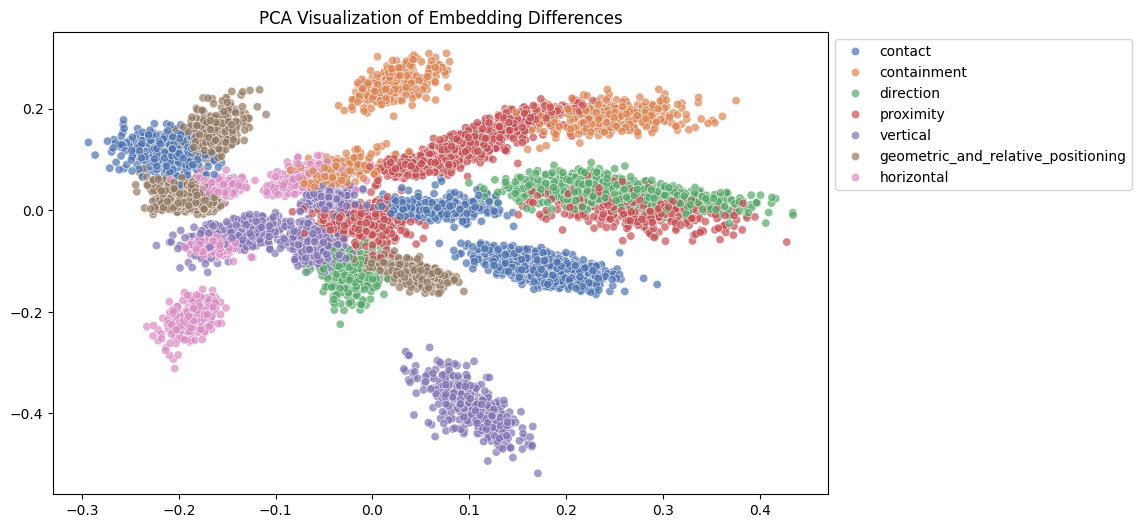

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

N = embedding_diffs.shape[0]

sample_size = min(10000, N)
subset_indices = np.random.choice(N, size=sample_size, replace=False)
sampled_embeddings = embedding_diffs[subset_indices]
sampled_categories = np.array(categories)[subset_indices]

pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(sampled_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=sampled_categories, palette="deep", alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
plt.title("PCA Visualization of Embedding Differences")
plt.show()

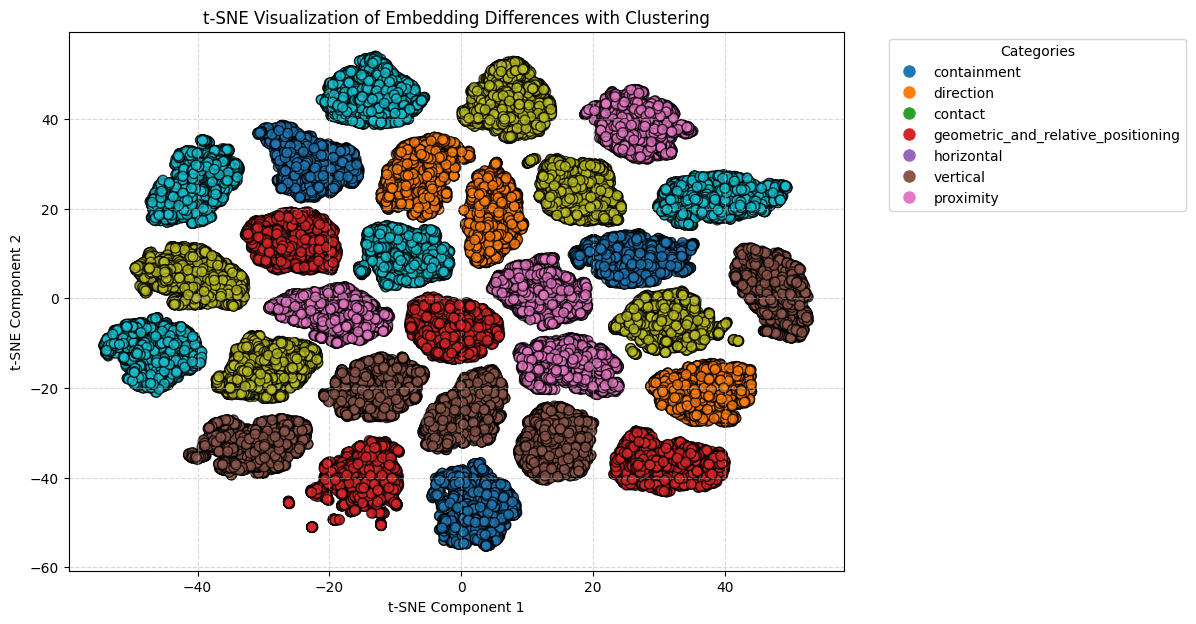

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

N = embedding_diffs.shape[0]

sample_size = min(10000, N)
subset_indices = np.random.choice(N, size=sample_size, replace=False)
sampled_embeddings = embedding_diffs[subset_indices]
sampled_categories = np.array(categories)[subset_indices]

# Reduce dimensionality with PCA first (to 20D)
pca = PCA(n_components=20, random_state=42)
reduced_embeddings = pca.fit_transform(embedding_diffs)

# Apply t-SNE (2D projection)
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, init='random', random_state=42)
tsne_embeddings = tsne.fit_transform(reduced_embeddings)

# Convert categories to unique colors
unique_categories = list(set(categories))
category_to_color = {cat: idx for idx, cat in enumerate(unique_categories)}
colors = [category_to_color[cat] for cat in categories]

# Plot t-SNE results with clustering effect
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=colors, cmap="tab10", alpha=0.75, edgecolors="k", s=50)

# Create a legend mapping category names to colors
legend_labels = {idx: cat for cat, idx in category_to_color.items()}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(idx), markersize=10) 
           for idx in legend_labels.keys()]
plt.legend(handles, legend_labels.values(), title="Categories", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("t-SNE Visualization of Embedding Differences with Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()
